# Baseline Model

In [65]:
import numpy as np
import pandas as pd
import joblib
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline

In [66]:
# Load data
X_train = joblib.load("Data/Xtrain2.pkl")
Y_train = np.load('Data/Ytrain2.npy')

print(X_train.shape)
print(Y_train.shape)

(444, 3)
(14,)


In [67]:
# FILTERING OPTIONS - MODIFY THESE TO REMOVE EXERCISES OR PATIENTS

# Option 1: Remove specific exercises
# exercises_to_remove = ['E1', 'E2']  # Remove exercises E1 and E2
exercises_to_remove = []  # Keep all exercises

# Option 2: Remove specific patients
# patients_to_remove = [1, 5, 10]  # Remove patients 1, 5, and 10
patients_to_remove = []  # Keep all patients

In [68]:
# Apply filters if specified
if exercises_to_remove:
    original_count = len(X_train)
    X_train = X_train[~X_train['Exercise_Id'].isin(exercises_to_remove)]
    print(f"Removed exercises {exercises_to_remove}. Sequences: {original_count} -> {len(X_train)}")

if patients_to_remove:
    original_count = len(X_train)
    X_train = X_train[~X_train['Patient_Id'].isin(patients_to_remove)]
    print(f"Removed patients {patients_to_remove}. Sequences: {original_count} -> {len(X_train)}")

# Get patient IDs from the filtered data
patient_ids = np.sort(X_train['Patient_Id'].unique())
print(f"Patient IDs in filtered data: {patient_ids}")

Patient IDs in filtered data: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [69]:
# Create patient-to-label mapping from the original Y_train
# We need to filter Y_train to only include patients that remain after filtering
all_patient_to_label = dict(zip(range(1, 15), Y_train))  # Original mapping for patients 1-14
patient_to_label = {pid: all_patient_to_label[pid] for pid in patient_ids}
Y_train_filtered = np.array([patient_to_label[pid] for pid in patient_ids])

print(f"Filtered data: {X_train.shape[0]} sequences, {len(patient_ids)} patients")
print(f"Class distribution: {np.sum(Y_train_filtered==0)} left vs {np.sum(Y_train_filtered==1)} right impaired")

Filtered data: 444 sequences, 14 patients
Class distribution: 9 left vs 5 right impaired


In [70]:
# Feature extraction function
def extract_features(df):
    features_list = []
    
    for idx, row in df.iterrows():
        # skeleton_seq shape: (seq_length, 33, 2)
        skeleton_seq = row['Skeleton_Sequence']
        
        # Flatten to (seq_length, 66)
        flattened = skeleton_seq.reshape(len(skeleton_seq), -1)
        
        # Mean and variance for each of 66 coordinates
        means = np.mean(flattened, axis=0)
        variances = np.var(flattened, axis=0)
        
        features_list.append(np.concatenate([means, variances]))
    
    return np.array(features_list)

In [71]:
# Define left and right side keypoints
LEFT_SIDE_KEYPOINTS = [11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31]  # Left body parts
RIGHT_SIDE_KEYPOINTS = [12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32]  # Right body parts

def calculate_velocity(sequence):
    """Calculate velocity between consecutive frames"""
    # sequence shape: (seq_length, 33, 2)
    velocity = np.diff(sequence, axis=0)  # (seq_length-1, 33, 2)
    return velocity

def calculate_side_velocity_stats(velocity_sequence, side_keypoints):
    """Calculate velocity statistics for a body side"""
    # velocity_sequence shape: (seq_length-1, 33, 2)
    side_velocity = velocity_sequence[:, side_keypoints, :]  # (seq_length-1, n_keypoints, 2)
    
    # Calculate magnitude of velocity vectors
    velocity_magnitudes = np.sqrt(np.sum(side_velocity**2, axis=2))  # (seq_length-1, n_keypoints)
    
    # Aggregate statistics
    mean_velocity = np.mean(velocity_magnitudes)
    std_velocity = np.std(velocity_magnitudes)
    max_velocity = np.max(velocity_magnitudes)
    
    return mean_velocity, std_velocity, max_velocity

def calculate_acceleration(velocity_sequence):
    """Calculate acceleration from velocity sequence"""
    # velocity_sequence shape: (seq_length-1, 33, 2)
    acceleration = np.diff(velocity_sequence, axis=0)  # (seq_length-2, 33, 2)
    return acceleration

def calculate_side_acceleration_stats(acceleration_sequence, side_keypoints):
    """Calculate acceleration statistics for a body side"""
    # acceleration_sequence shape: (seq_length-2, 33, 2)
    side_acceleration = acceleration_sequence[:, side_keypoints, :]  # (seq_length-2, n_keypoints, 2)
    
    # Calculate magnitude of acceleration vectors
    acceleration_magnitudes = np.sqrt(np.sum(side_acceleration**2, axis=2))  # (seq_length-2, n_keypoints)
    
    # Aggregate statistics
    mean_acceleration = np.mean(acceleration_magnitudes)
    std_acceleration = np.std(acceleration_magnitudes)
    max_acceleration = np.max(acceleration_magnitudes)
    
    return mean_acceleration, std_acceleration, max_acceleration

def calculate_asymmetry_features(left_stats, right_stats):
    """Calculate asymmetry ratios between left and right sides"""
    left_mean_vel, left_std_vel, left_max_vel = left_stats['velocity']
    right_mean_vel, right_std_vel, right_max_vel = right_stats['velocity']
    
    left_mean_acc, left_std_acc, left_max_acc = left_stats['acceleration']
    right_mean_acc, right_std_acc, right_max_acc = right_stats['acceleration']
    
    # Velocity asymmetry ratios
    vel_mean_ratio = left_mean_vel / (right_mean_vel + 1e-8)  # Avoid division by zero
    vel_std_ratio = left_std_vel / (right_std_vel + 1e-8)
    vel_max_ratio = left_max_vel / (right_max_vel + 1e-8)
    
    # Acceleration asymmetry ratios
    acc_mean_ratio = left_mean_acc / (right_mean_acc + 1e-8)
    acc_std_ratio = left_std_acc / (right_std_acc + 1e-8)
    acc_max_ratio = left_max_acc / (right_max_acc + 1e-8)
    
    return [vel_mean_ratio, vel_std_ratio, vel_max_ratio, 
            acc_mean_ratio, acc_std_ratio, acc_max_ratio]

def extract_dynamic_features(df):
    dynamic_features_list = []
    
    for idx, row in df.iterrows():
        skeleton_seq = np.array(row['Skeleton_Sequence'])


        skeleton_seq = skeleton_seq.reshape(skeleton_seq.shape[0], 33, 2)

        # Calculate velocity and acceleration
        velocity = calculate_velocity(skeleton_seq)
        acceleration = calculate_acceleration(velocity)
        
        # Calculate statistics for each side
        left_vel_stats = calculate_side_velocity_stats(velocity, LEFT_SIDE_KEYPOINTS)
        right_vel_stats = calculate_side_velocity_stats(velocity, RIGHT_SIDE_KEYPOINTS)
        
        left_acc_stats = calculate_side_acceleration_stats(acceleration, LEFT_SIDE_KEYPOINTS)
        right_acc_stats = calculate_side_acceleration_stats(acceleration, RIGHT_SIDE_KEYPOINTS)
        
        # Create feature dictionaries
        left_stats = {'velocity': left_vel_stats, 'acceleration': left_acc_stats}
        right_stats = {'velocity': right_vel_stats, 'acceleration': right_acc_stats}
        
        # Calculate asymmetry features
        asymmetry_features = calculate_asymmetry_features(left_stats, right_stats)
        
        # Combine all dynamic features
        dynamic_features = [
            *left_vel_stats, *right_vel_stats,
            *left_acc_stats, *right_acc_stats,
            *asymmetry_features
        ]
        
        dynamic_features_list.append(dynamic_features)
    
    return np.array(dynamic_features_list)


In [72]:
# Extract features for all sequences
static_features = extract_features(X_train)
dynamic_features = extract_dynamic_features(X_train)

# Prepare one-hot encoder for exercises
exercise_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
exercise_encoded = exercise_encoder.fit_transform(X_train[['Exercise_Id']])

# Combine features with exercise encoding
X_combined = np.concatenate([
    static_features, 
    dynamic_features, 
    exercise_encoded
    ], axis=1)

# Create sequence-level labels
patient_to_label = dict(zip(patient_ids, Y_train))
y_sequences = X_train['Patient_Id'].map(patient_to_label).values

# Store patient ID for each sequence
sequence_patient_ids = X_train['Patient_Id'].values

In [73]:
X_combined[0]

array([ 1.19733912e-03, -5.65041175e-01,  1.50232159e-02, -5.90743209e-01,
        1.83890064e-02, -5.90576831e-01,  1.58385386e-02, -5.90982177e-01,
       -7.57782500e-03, -5.93582941e-01, -3.81967188e-03, -5.92943849e-01,
        9.05467424e-04, -5.84129801e-01,  7.47027613e-02, -5.76397716e-01,
       -5.48540568e-02, -5.25465254e-01,  4.08378212e-02, -5.57124736e-01,
        8.62539943e-03, -5.19998277e-01,  1.92334260e-01, -4.19843892e-01,
       -1.35340785e-01, -4.79021439e-01,  2.42496352e-01, -2.16031929e-01,
       -2.21562543e-01, -2.78345187e-01,  2.10580915e-01, -3.52807414e-02,
       -1.08712225e-01, -2.85554500e-01,  1.89105874e-01,  8.73673867e-03,
       -5.02839747e-02, -2.82023093e-01,  1.47100941e-01,  6.96730483e-03,
       -9.50986984e-03, -3.38909182e-01,  1.92108549e-01, -7.51216143e-03,
       -8.43244232e-02, -3.01323159e-01,  1.01910927e-01, -3.83950593e-03,
       -1.00125355e-01,  1.69220185e-03,  2.76740440e-01,  1.84318775e-01,
       -1.39805395e-01,  

In [74]:
# Feature names for interpretation
keypoint_names = [
    'nose', 
    'left_eye_inner', 'left_eye', 'left_eye_outer', 
    'right_eye_inner', 'right_eye', 'right_eye_outer',
    'left_ear', 'right_ear', 
    'mouth_left', 'mouth_right', 
    'left_shoulder', 'right_shoulder',
    'left_elbow', 'right_elbow', 
    'left_wrist', 'right_wrist', 
    'left_pinky', 'right_pinky',
    'left_index', 'right_index', 
    'left_thumb', 'right_thumb', 
    'left_hip', 'right_hip',
    'left_knee', 'right_knee', 
    'left_ankle', 'right_ankle', 
    'left_heel', 'right_heel',
    'left_foot_index', 'right_foot_index'
]

# Create feature names for means and variances
feature_names = []
for name in keypoint_names:
    feature_names.append(f'{name}_mean_x')
    feature_names.append(f'{name}_mean_y')
for name in keypoint_names:
    feature_names.append(f'{name}_var_x')
    feature_names.append(f'{name}_var_y')

# Add dynamic feature names
dynamic_feature_names = [
    # Velocity features (6)
    'left_side_mean_velocity', 'left_side_std_velocity', 'left_side_max_velocity',
    'right_side_mean_velocity', 'right_side_std_velocity', 'right_side_max_velocity',
    
    # Acceleration features (6)
    'left_side_mean_acceleration', 'left_side_std_acceleration', 'left_side_max_acceleration',
    'right_side_mean_acceleration', 'right_side_std_acceleration', 'right_side_max_acceleration',
    
    # Asymmetry ratios (6)
    'velocity_mean_asymmetry_ratio', 'velocity_std_asymmetry_ratio', 'velocity_max_asymmetry_ratio',
    'acceleration_mean_asymmetry_ratio', 'acceleration_std_asymmetry_ratio', 'acceleration_max_asymmetry_ratio'
]

# Add exercise feature names
exercise_feature_names = [f'exercise_{ex}' for ex in exercise_encoder.categories_[0]]

# Combine all feature names
feature_names.extend(dynamic_feature_names)
feature_names.extend(exercise_feature_names)

print(f"Total features: {len(feature_names)}")
print(f"  - Static features: {66 * 2} (means + variances)")
print(f"  - Dynamic features: {len(dynamic_feature_names)}")
print(f"  - Exercise features: {len(exercise_feature_names)}")

Total features: 155
  - Static features: 132 (means + variances)
  - Dynamic features: 18
  - Exercise features: 5


In [75]:
# Cross-validation setup
n_splits = 364
majority_accuracies = []
probability_accuracies = []

In [76]:
for split in tqdm(range(n_splits), desc="Cross-validation splits", unit="split"):
    # Random stratified split: 2 left + 1 right patients for test
    rng = np.random.RandomState(42 + split)
    
    left_patients = patient_ids[Y_train == 0]  # Patients with label 0
    right_patients = patient_ids[Y_train == 1]  # Patients with label 1
    
    test_left = rng.choice(left_patients, size=2, replace=False)
    test_right = rng.choice(right_patients, size=1, replace=False)
    test_patients = np.concatenate([test_left, test_right])
    train_patients = np.setdiff1d(patient_ids, test_patients)
    
    # Create masks for sequences (much faster than filtering DataFrame)
    train_mask = np.isin(sequence_patient_ids, train_patients)
    test_mask = np.isin(sequence_patient_ids, test_patients)
    
    # Split the precomputed features
    X_train_split = X_combined[train_mask]
    X_test_split = X_combined[test_mask]
    y_train_split = y_sequences[train_mask]
    y_test_split = y_sequences[test_mask]
    test_patient_ids_split = sequence_patient_ids[test_mask]
     
    # Train SVM
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42))
    ])
    
    model.fit(X_train_split, y_train_split)
    
    # Get both predictions and probabilities for test sequences
    test_sequence_preds = model.predict(X_test_split)
    test_sequence_probs = model.predict_proba(X_test_split)
    
    # METHOD 1: Majority Voting
    patient_predictions = {}
    for i, patient_id in enumerate(test_patient_ids_split):
        if patient_id not in patient_predictions:
            patient_predictions[patient_id] = []
        patient_predictions[patient_id].append(test_sequence_preds[i])
    
    majority_preds = []
    true_labels = []
    for patient_id in test_patients:
        votes = patient_predictions[patient_id]
        pred_label = np.argmax(np.bincount(votes))
        majority_preds.append(pred_label)
        true_labels.append(patient_to_label[patient_id])
    
    majority_acc = balanced_accuracy_score(true_labels, majority_preds)
    majority_accuracies.append(majority_acc)
    
    # METHOD 2: Probability Averaging
    patient_probs = {}
    for i, patient_id in enumerate(test_patient_ids_split):
        if patient_id not in patient_probs:
            patient_probs[patient_id] = []
        patient_probs[patient_id].append(test_sequence_probs[i])
    
    probability_preds = []
    for patient_id in test_patients:
        avg_probs = np.mean(patient_probs[patient_id], axis=0)
        pred_label = np.argmax(avg_probs)
        probability_preds.append(pred_label)
    
    probability_acc = balanced_accuracy_score(true_labels, probability_preds)
    probability_accuracies.append(probability_acc)


Cross-validation splits: 100%|██████████| 364/364 [00:09<00:00, 37.99split/s]


In [77]:
# Final results comparison
print(f"\n=== COMPARISON RESULTS ===\n")
print(f"MAJORITY VOTING:")
print(f"  Mean Balanced Accuracy: {np.mean(majority_accuracies):.4f} (±{np.std(majority_accuracies):.4f})")
print(f"  Min: {np.min(majority_accuracies):.4f}, Max: {np.max(majority_accuracies):.4f}")

print(f"\nPROBABILITY AVERAGING:")
print(f"  Mean Balanced Accuracy: {np.mean(probability_accuracies):.4f} (±{np.std(probability_accuracies):.4f})")
print(f"  Min: {np.min(probability_accuracies):.4f}, Max: {np.max(probability_accuracies):.4f}")


=== COMPARISON RESULTS ===

MAJORITY VOTING:
  Mean Balanced Accuracy: 0.5309 (±0.2456)
  Min: 0.0000, Max: 1.0000

PROBABILITY AVERAGING:
  Mean Balanced Accuracy: 0.5227 (±0.2742)
  Min: 0.0000, Max: 1.0000


In [78]:
# Analyze feature importance for each exercise separately
exercises = ['E1', 'E2', 'E3', 'E4', 'E5']
results = {}

for exercise in exercises:
    print(f"\n=== Analyzing feature importance for {exercise} ===")
    
    # Filter data for this exercise
    exercise_mask = (X_train['Exercise_Id'] == exercise)
    X_exercise = X_combined[exercise_mask]
    y_exercise = y_sequences[exercise_mask]
    
    if len(X_exercise) == 0:
        print(f"No data for exercise {exercise}")
        continue
    
    print(f"Samples for {exercise}: {len(X_exercise)}")
    
    # Train model on this exercise only
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(kernel='linear', class_weight='balanced', random_state=42))  # Using linear for interpretable coefficients
    ])
    
    model.fit(X_exercise, y_exercise)
    
    # Get feature importance from linear SVM coefficients
    if hasattr(model.named_steps['svm'], 'coef_'):
        # For linear SVM, use absolute coefficients as importance
        coefficients = np.abs(model.named_steps['svm'].coef_[0])
        
        # Create DataFrame with feature importance
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': coefficients
        })
        
        # Sort by importance
        importance_df = importance_df.sort_values('importance', ascending=False)
        
        results[exercise] = importance_df
        
        print(f"\nTop 40 most important features for {exercise}:")
        print(importance_df.head(40))
        


=== Analyzing feature importance for E1 ===
Samples for E1: 51

Top 40 most important features for E1:
                          feature  importance
117               left_knee_var_y    0.228145
50               left_knee_mean_x    0.199760
28             right_elbow_mean_x    0.162410
52              right_knee_mean_x    0.151662
60              right_heel_mean_x    0.138546
38              left_index_mean_x    0.137224
42              left_thumb_mean_x    0.135975
34              left_pinky_mean_x    0.131289
30              left_wrist_mean_x    0.126270
49               right_hip_mean_y    0.119739
126              right_heel_var_x    0.110195
56             right_ankle_mean_x    0.107543
58               left_heel_mean_x    0.103705
138   left_side_mean_acceleration    0.096136
53              right_knee_mean_y    0.092529
25          right_shoulder_mean_y    0.087442
47                left_hip_mean_y    0.086960
48               right_hip_mean_x    0.086587
122             right_

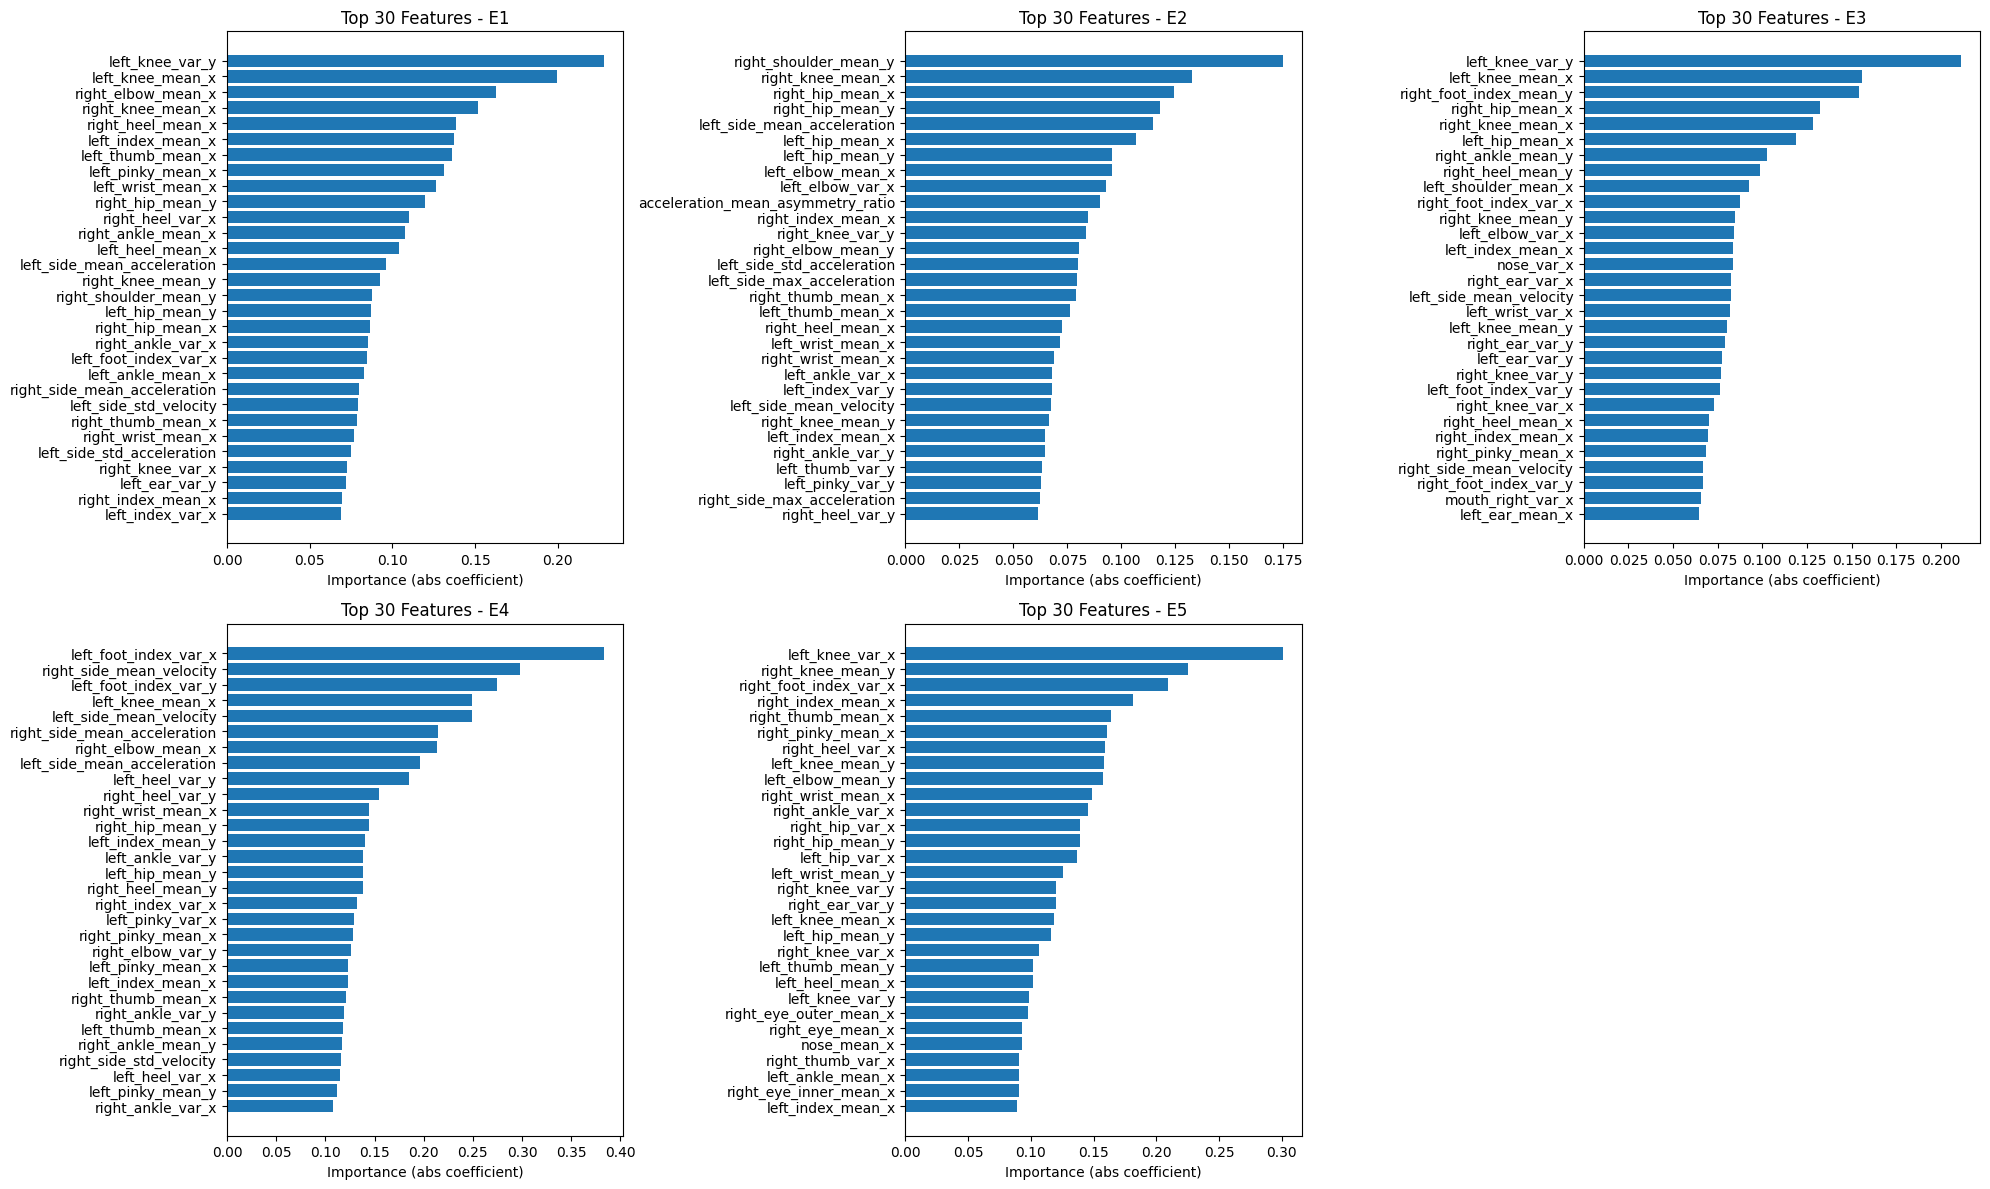

In [79]:
# Plot feature importance for each exercise
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.ravel()

for i, exercise in enumerate(exercises):
    if exercise in results:
        # Get top 20 features for this exercise
        top_features = results[exercise].head(30)
        
        # Plot
        axes[i].barh(range(len(top_features)), top_features['importance'])
        axes[i].set_yticks(range(len(top_features)))
        axes[i].set_yticklabels(top_features['feature'])
        axes[i].set_title(f'Top 30 Features - {exercise}')
        axes[i].set_xlabel('Importance (abs coefficient)')
        
        # Invert y-axis to have highest importance at top
        axes[i].invert_yaxis()

# Remove empty subplot if needed
if len(exercises) < 6:
    for i in range(len(exercises), 6):
        fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [80]:
# Combine all results into one DataFrame
combined_df = pd.concat(
    [df.assign(exercise=ex) for ex, df in results.items()],
    ignore_index=True
)

# Save combined CSV
combined_df.to_csv("feature_importance_v2_baseline.csv", index=False)
print("Saved all feature importances to feature_importance_v2_baseline.csv")


Saved all feature importances to feature_importance_v2_baseline.csv
